In [1]:
import pandas as pd
import joblib

import warnings
from afl_match_outcome_model.modelling.hyperparameter_tuning import (
    XGBRoundCVHyperparameterTuner
)
from afl_match_outcome_model.modelling.supermodel import SuperXGBClassifier
from afl_match_outcome_model.modelling.optuna_xgb_param_grid import OptunaXGBParamGrid
from afl_match_outcome_model.evaluation.model_evaluation import XGBClassifierEvaluator

warnings.filterwarnings("ignore")
pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

/Users/ciaran/opt/anaconda3/envs/afl-outcome-model-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Load all Datasets

In [2]:
from afl_match_outcome_model.data_preparation.data_loader import load_matches, load_player_stats, load_venues, load_team_info

matches = load_matches()
player_stats = load_player_stats()
venue_info = load_venues()
home_info, away_info = load_team_info()

Merging Datasets

In [3]:
from afl_match_outcome_model.data_preparation.preprocessing import merge_venue_info, merge_home_away_venue

In [4]:
matches = merge_venue_info(matches, venue_info)
matches = merge_home_away_venue(matches, home_info, away_info, venue_info)

In [5]:
from afl_match_outcome_model.data_preparation.match_id_utils import get_round_from_match_id

In [6]:
matches['Round'] = matches['Match_ID'].apply(lambda match_id: get_round_from_match_id(match_id))

Player Stats -> Team Stats (Aggregation)

In [7]:
from afl_match_outcome_model.data_preparation.match_id_utils import get_home_team_from_match_id, get_away_team_from_match_id
from afl_match_outcome_model.data_preparation.preprocessing import create_home_flag

In [8]:
player_stats['Home_Team'] = player_stats['Match_ID'].apply(lambda match_id: get_home_team_from_match_id(match_id))
player_stats['Away_Team'] = player_stats['Match_ID'].apply(lambda match_id: get_away_team_from_match_id(match_id))
player_stats['Home'] = create_home_flag(player_stats)

In [9]:
from afl_match_outcome_model.data_preparation.utils import get_numeric_columns_list

In [10]:
numeric_player_stats = get_numeric_columns_list(player_stats)

In [11]:
from afl_match_outcome_model.data_preparation.aggregation import aggregate_player_stats_to_team_stats
from afl_match_outcome_model.data_preparation.preprocessing import merge_match_summary_team_stats

In [12]:
team_stats = aggregate_player_stats_to_team_stats(player_stats, numeric_player_stats)

In [13]:
match_stats = merge_match_summary_team_stats(matches, team_stats)
match_stats.head(1)

,Home_Team,Away_Team,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Margin,Total Game Score,Home Win,Venue,City,Date,Attendance,Umpires,Home_Coach_ID,Away_Coach_ID,Match_ID,Q5_Score,Venue_Latitude,Venue_Longitude,Home_Team_Venue,Away_Team_Venue,Home_Team_Venue_Latitude,Home_Team_Venue_Longitude,Away_Team_Venue_Latitude,Away_Team_Venue_Longitude,Round,Home_Height,Home_Weight,Home_Number,Home_Kicks,Home_Marks,Home_Handballs,Home_Disposals,Home_Effective_Disposals,Home_Disposal_Efficiency,Home_Goals,Home_Behinds,Home_Hit_Outs,Home_Tackles,Home_Rebound_50s,Home_Inside_50s,Home_Clearances,Home_Clangers,Home_Frees_For,Home_Frees_Against,Home_Brownlow_Votes,Home_Contested_Possessions,Home_Uncontested_Possessions,Home_Contested_Marks,Home_Marks_Inside_50,Home_One_Percenters,Home_Bounces,Home_Goal_Assists,Home_Percent_Played,Home_AFL_Fantasy_Points,Home_Super_Coach_Points,Home_Centre_Clearances,Home_Stoppage_Clearances,Home_Score_Involvements,Home_Metres_Gained,Home_Turnovers,Home_Intercepts,Home_Tackles_Inside_50,Home_Defensive_Contest_Losses,Home_Defensive_One_On_One_Contests,Home_Offensive_One_On_One_Contests,Home_Offensive_Contest_Wins,Home_Defensive_Half_Pressure_Acts,Home_Effective_Kicks,Home_Inside_50_Ground_Ball_Gets,Home_Ground_Ball_Gets,Home_Hit_Outs_To_Advantage,Home_Hit_Out_Win_Percentage,Home_Intercept_Marks,Home_Marks_On_Lead,Home_Pressure_Acts,Home_Player_Rating_Points,Home_Ruck_Contests,Home_Score_Launches,Home_Shots_At_Goal,Home_Spoils,Home_Home,Away_Height,Away_Weight,Away_Number,Away_Kicks,Away_Marks,Away_Handballs,Away_Disposals,Away_Effective_Disposals,Away_Disposal_Efficiency,Away_Goals,Away_Behinds,Away_Hit_Outs,Away_Tackles,Away_Rebound_50s,Away_Inside_50s,Away_Clearances,Away_Clangers,Away_Frees_For,Away_Frees_Against,Away_Brownlow_Votes,Away_Contested_Possessions,Away_Uncontested_Possessions,Away_Contested_Marks,Away_Marks_Inside_50,Away_One_Percenters,Away_Bounces,Away_Goal_Assists,Away_Percent_Played,Away_AFL_Fantasy_Points,Away_Super_Coach_Points,Away_Centre_Clearances,Away_Stoppage_Clearances,Away_Score_Involvements,Away_Metres_Gained,Away_Turnovers,Away_Intercepts,Away_Tackles_Inside_50,Away_Defensive_Contest_Losses,Away_Defensive_One_On_One_Contests,Away_Offensive_One_On_One_Contests,Away_Offensive_Contest_Wins,Away_Defensive_Half_Pressure_Acts,Away_Effective_Kicks,Away_Inside_50_Ground_Ball_Gets,Away_Ground_Ball_Gets,Away_Hit_Outs_To_Advantage,Away_Hit_Out_Win_Percentage,Away_Intercept_Marks,Away_Marks_On_Lead,Away_Pressure_Acts,Away_Player_Rating_Points,Away_Ruck_Contests,Away_Score_Launches,Away_Shots_At_Goal,Away_Spoils,Away_Home
0,Adelaide,Western Bulldogs,3.2.20 - 7.6.48,9.11.65 - 8.7.55,11.13.79 - 14.15.99,15.18.108 - 19.17.131,-23,239,0.0,Football Park,Adelaide,2000-03-11 04:20:00,37222.0,"Bryan Sheehan (285), Darren McCauley (52), Tro...",Gary_Ayres,Terry_Wallace,AFL_2000_01_Adelaide_WesternBulldogs,NaN,-34.879899,138.495516,Adelaide Oval,Docklands,-34.91558,138.596317,-37.816565,144.947506,1,0.0,0.0,421.0,166.0,59.0,95.0,261.0,0.0,0.0,15.0,16.0,21.0,25.0,32.0,55.0,32.0,22.0,21.0,23.0,0.0,121.0,142.0,4.0,10.0,22.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,361.0,211.0,89.0,121.0,332.0,0.0,0.0,19.0,14.0,11.0,25.0,38.0,59.0,42.0,26.0,23.0,21.0,6.0,134.0,198.0,16.0,23.0,18.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Feature Engineering

In [14]:
from afl_match_outcome_model.data_preparation.match_id_utils import get_season_from_match_id

In [15]:
match_stats['Year'] = match_stats['Match_ID'].apply(lambda match_id: get_season_from_match_id(match_id))

In [16]:
from afl_match_outcome_model.data_preparation.elo import create_elo_ratings_home_away

In [17]:
match_stats = create_elo_ratings_home_away(match_stats, 32)

In [18]:
from afl_match_outcome_model.data_preparation.feature_engineering import create_score_features, create_margin_features, create_win_features

In [19]:
match_stats = create_score_features(match_stats)
match_stats = create_margin_features(match_stats)
match_stats = create_win_features(match_stats)

In [20]:
rolling_feature_list = ['Win', 'Margin', 'Score', 'Goals', 'Player_Rating_Points', 'ELO']

In [21]:
from afl_match_outcome_model.data_preparation.rolling import create_team_rolling_features

In [22]:
rolling_span = 5
match_stats = create_team_rolling_features(match_stats, rolling_feature_list, rolling_span)

In [23]:
from afl_match_outcome_model.data_preparation.feature_engineering import create_distance_travelled_feature, create_home_away_diff_feature

In [24]:
match_stats = create_distance_travelled_feature(match_stats)

In [25]:
feature_diff_list = [
    'Win_For_ewm5',
    'Margin_For_ewm5',
    'Score_For_ewm5',
    'Goals_For_ewm5',
    'Player_Rating_Points_For_ewm5',
    'ELO_For_ewm5',
    'Distance_Travelled'
]

In [26]:
match_stats = create_home_away_diff_feature(match_stats, feature_diff_list)

Remove Outliers

In [27]:
from afl_match_outcome_model.data_preparation.preprocessing import filter_draws, outlier_eliminator, min_year_filter_data, sort_match_stats

In [28]:
match_stats = filter_draws(match_stats)
match_stats = outlier_eliminator(match_stats)
match_stats = min_year_filter_data(match_stats, 2012)
match_stats = sort_match_stats(match_stats)

Train Test Split

In [29]:
modelling_feature_list = [
    f'Win_For_ewm{rolling_span}_diff',
    f'Margin_For_ewm{rolling_span}_diff',
    f'Score_For_ewm{rolling_span}_diff',
    f'Goals_For_ewm{rolling_span}_diff',
    f'Player_Rating_Points_For_ewm{rolling_span}_diff',
    f'ELO_For_ewm{rolling_span}_diff',
    'Distance_Travelled_diff'
]

In [30]:
df_train = match_stats[match_stats['Year'] < 2022]
df_test = match_stats[match_stats['Year'] >= 2022]

X_train, y_train = df_train[['Year', 'Round'] + modelling_feature_list], df_train['Home_Win']
X_test, y_test = df_test[['Year', 'Round'] + modelling_feature_list], df_test['Home_Win']

In [31]:
y_train.mean(), y_test.mean()

(0.5598787266296109, 0.5904761904761905)

Time Series Cross Validation

In [32]:
xgb_tuner = XGBRoundCVHyperparameterTuner(
    X_train, y_train, monotonicity_constraints={}
)

In [33]:
xgb_tuner.tune_hyperparameters()

[I 2024-01-28 19:28:15,442] A new study created in memory with name: no-name-c7a1f9d3-b29b-45be-9a2b-d78f551b4850
[I 2024-01-28 19:28:18,121] Trial 0 finished with value: 0.6788998714592708 and parameters: {'max_depth': 19, 'min_child_weight': 23, 'eta': 0.029393726711273348, 'gamma': 0.00011266076401100235, 'lambda': 0.0011053667783000331, 'alpha': 2.137664603696696, 'subsample': 0.23869211831260642, 'colsample_bytree': 0.2664512451579715}. Best is trial 0 with value: 0.6788998714592708.
[I 2024-01-28 19:28:20,542] Trial 1 finished with value: 0.6713375100890672 and parameters: {'max_depth': 4, 'min_child_weight': 23, 'eta': 0.01386113204695742, 'gamma': 0.19633031330401554, 'lambda': 0.00010083381930741463, 'alpha': 0.0409883695094031, 'subsample': 0.7795393271883424, 'colsample_bytree': 0.7986788904191877}. Best is trial 1 with value: 0.6713375100890672.
[I 2024-01-28 19:28:22,579] Trial 2 finished with value: 0.6756738606536133 and parameters: {'max_depth': 16, 'min_child_weight': 

Number of finished trials:  100
Best trial:
  Value: 0.608975559541525
  Params: 
    max_depth: 10
    min_child_weight: 8
    eta: 0.21520978263656484
    gamma: 4.469899843814371
    lambda: 0.0015758429442753867
    alpha: 0.05226387256934298
    subsample: 0.8141981597521086
    colsample_bytree: 0.7673732142741869


In [34]:
params = xgb_tuner.get_best_params()
params

{'max_depth': 10,
 'min_child_weight': 8,
 'eta': 0.21520978263656484,
 'gamma': 4.469899843814371,
 'lambda': 0.0015758429442753867,
 'alpha': 0.05226387256934298,
 'subsample': 0.8141981597521086,
 'colsample_bytree': 0.7673732142741869}

Training Model - SuperXGBClassifier class for training and predictions

In [35]:
params["objective"] = OptunaXGBParamGrid.error
params["num_rounds"] = 1000
params["early_stopping_rounds"] = 10
params["verbosity"] = 1
params["monotone_constraints"] = {}

In [36]:
super_xgb = SuperXGBClassifier(
    X_train[modelling_feature_list], y_train,
    X_test[modelling_feature_list], y_test,
    params=params
)

In [37]:
super_xgb.fit()

[0]	validation_0-logloss:0.64462	validation_1-logloss:0.65043
[1]	validation_0-logloss:0.62167	validation_1-logloss:0.63444
[2]	validation_0-logloss:0.60598	validation_1-logloss:0.62403
[3]	validation_0-logloss:0.59504	validation_1-logloss:0.61628
[4]	validation_0-logloss:0.58465	validation_1-logloss:0.61162
[5]	validation_0-logloss:0.57965	validation_1-logloss:0.60815
[6]	validation_0-logloss:0.57462	validation_1-logloss:0.60644
[7]	validation_0-logloss:0.57005	validation_1-logloss:0.60581
[8]	validation_0-logloss:0.56509	validation_1-logloss:0.60271
[9]	validation_0-logloss:0.56379	validation_1-logloss:0.60240
[10]	validation_0-logloss:0.56170	validation_1-logloss:0.60172
[11]	validation_0-logloss:0.56056	validation_1-logloss:0.60251
[12]	validation_0-logloss:0.55717	validation_1-logloss:0.60003
[13]	validation_0-logloss:0.55489	validation_1-logloss:0.60126
[14]	validation_0-logloss:0.55394	validation_1-logloss:0.60025
[15]	validation_0-logloss:0.55363	validation_1-logloss:0.59942
[1

In [38]:
match_stats['xgb_preds'] = super_xgb.predict(match_stats[modelling_feature_list])
df_train['xgb_preds'] = super_xgb.predict(df_train[modelling_feature_list])
df_test['xgb_preds'] = super_xgb.predict(df_test[modelling_feature_list])

In [39]:
match_stats['xgb_probas'] = super_xgb.predict_proba(match_stats[modelling_feature_list])[:, 1]
df_train['xgb_probas'] = super_xgb.predict_proba(df_train[modelling_feature_list])[:, 1]
df_test['xgb_probas'] = super_xgb.predict_proba(df_test[modelling_feature_list])[:, 1]

Check Average Predictions

In [40]:
match_stats['Home_Win'].mean(), match_stats['xgb_probas'].mean()

(0.5652355147978324, 0.5575056)

Model Evaluation

In [41]:
df_train['baseline'] = df_train['Home_Win'].mean()
df_train['baseline_label'] = 1

train_xgb_evals = XGBClassifierEvaluator(
    model=super_xgb.xgb_model,
    data=df_train,
    actual_name='Home_Win',
    expected_name="xgb_probas",
    expected_label_name="xgb_preds",
    compare_name="baseline",
    compare_label_name="baseline_label"
)

In [42]:
df_test['baseline'] = df_train['Home_Win'].mean()
df_test['baseline_label'] = 1

df_test_eval = df_test[df_test['Round'] > 5]

test_xgb_evals = XGBClassifierEvaluator(
    model=super_xgb.xgb_model,
    data=df_test_eval,
    actual_name='Home_Win',
    expected_name="xgb_probas",
    expected_label_name="xgb_preds",
    compare_name="baseline",
    compare_label_name="baseline_label"
)

baseline_xgb_evals = XGBClassifierEvaluator(
    model=super_xgb.xgb_model,
    data=df_test_eval,
    actual_name='Home_Win',
    expected_name="baseline",
    expected_label_name="baseline_label",
)


Model Averages

In [43]:
df_test[['Home_Win', "xgb_probas", 'xgb_probas', "baseline_label", "baseline"]].describe()

,Home_Win,xgb_probas,xgb_probas,baseline_label,baseline
count,420.000000,420.000000,420.000000,420.0,4.200000e+02
mean,0.590476,0.552874,0.552874,1.0,5.598787e-01
std,0.492332,0.193209,0.193209,0.0,1.111547e-16
min,0.000000,0.134888,0.134888,1.0,5.598787e-01
25%,0.000000,0.384578,0.384578,1.0,5.598787e-01
50%,1.000000,0.554580,0.554580,1.0,5.598787e-01
75%,1.000000,0.710446,0.710446,1.0,5.598787e-01
max,1.000000,0.935943,0.935943,1.0,5.598787e-01


Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [44]:
test_xgb_evals.get_log_loss(), test_xgb_evals.get_brier_score_loss(), test_xgb_evals.get_accuracy(), test_xgb_evals.get_recall(), test_xgb_evals.get_precision(), test_xgb_evals.get_f1_score()

Expected Log-Loss: 	0.5797
Compare Log-Loss: 	0.6833
Expected Brier Score: 	0.1970
Compare Brier Score: 	0.2451
Expected Accuracy: 	0.7251
Compare Accuracy: 	0.5710
Expected Recall: 	0.7778
Compare Recall: 	1.0000
Expected Precision: 	0.7500
Compare Precision: 	0.5710
Expected F1 Score: 	0.7636
Compare F1 Score: 	0.7269


((0.5797154426010414, 0.5797154426010414),
 (0.1970124694354378, 0.2450830445263737),
 (0.7250755287009063, 0.5709969788519638),
 (0.7777777777777778, 1.0),
 (0.75, 0.5709969788519638),
 (0.7636363636363638, 0.7269230769230769))

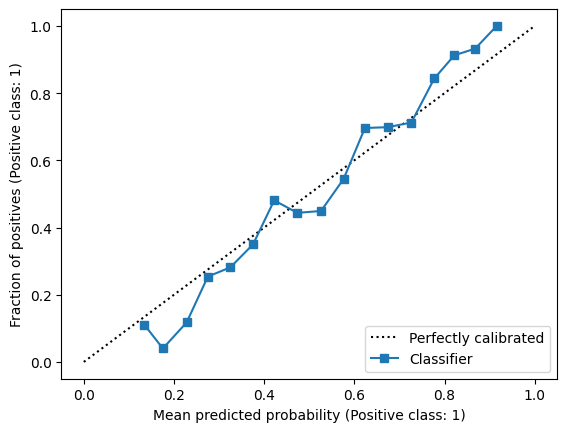

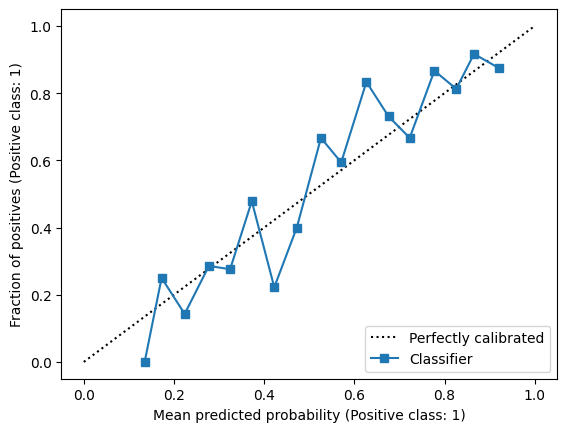

In [45]:
train_xgb_evals.display_calibration_curve(nbins=20)
test_xgb_evals.display_calibration_curve(nbins=20)

In [46]:
baseline_xgb_evals.get_confusion_matrix(), test_xgb_evals.get_confusion_matrix()

(array([[  0, 142],
        [  0, 189]]),
 array([[ 93,  49],
        [ 42, 147]]))

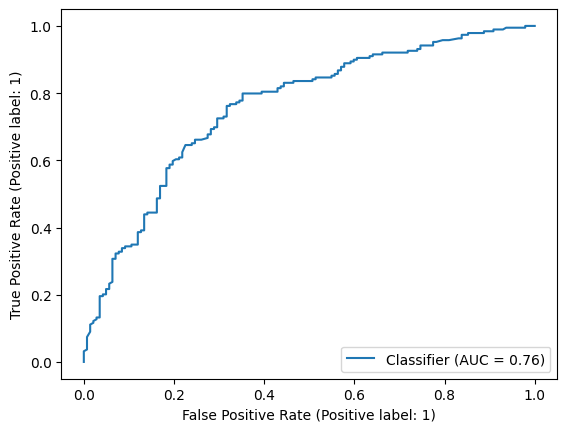

In [47]:
test_xgb_evals.plot_roc_curve()

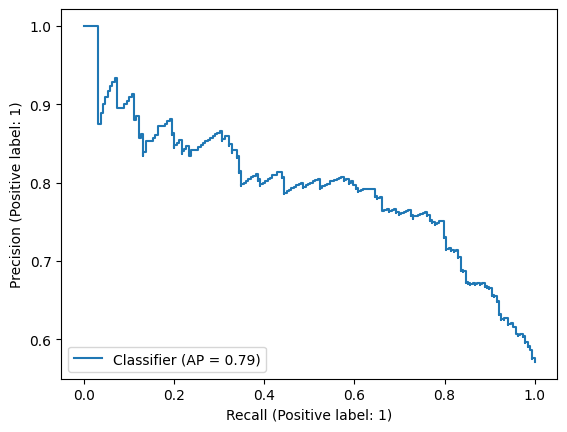

In [48]:
test_xgb_evals.plot_prauc_curve()

Plots

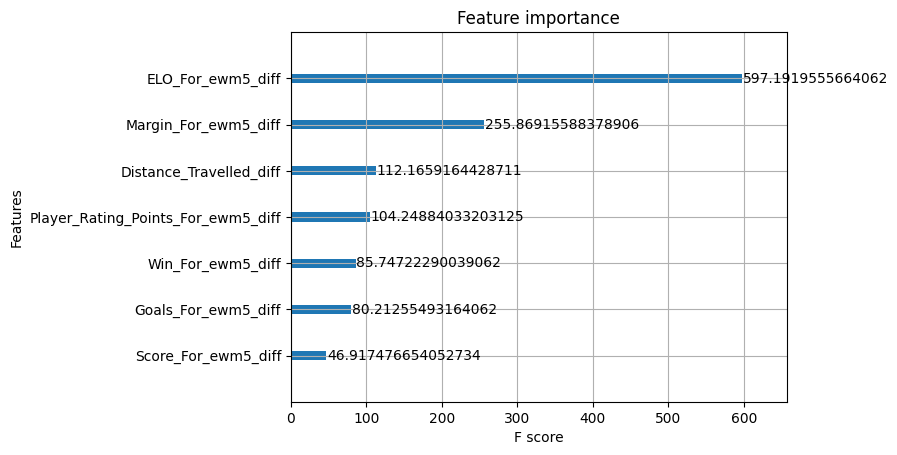

In [49]:
test_xgb_evals.plot_feature_importance(
    max_num_features=10, importance_type="total_gain"
)

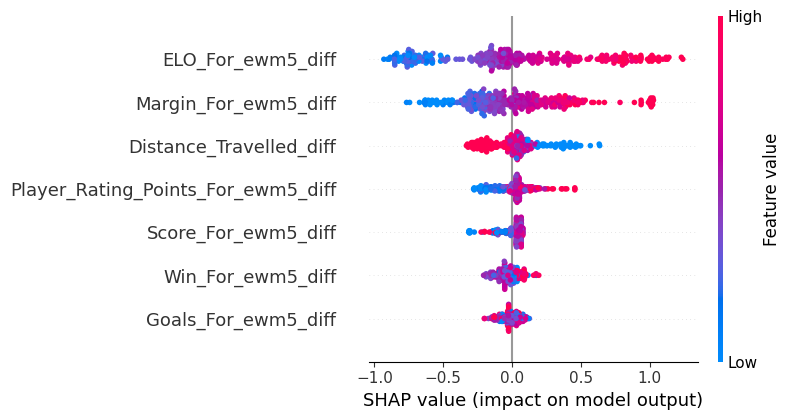

In [50]:
test_xgb_evals.plot_shap_summary_plot(sample=(len(df_test_eval)))

Export model

In [51]:
joblib.dump(super_xgb, "../model_outputs/match_outcome_xgb.joblib")

['../model_outputs/match_outcome_xgb.joblib']